# Access vroom via routing-py

This notebook demonstrates how to use [vroom](https://github.com/VROOM-Project/vroom) through routing-py. In this example, we'll connect to the [vroom demo server](http://map.vroom-project.org), but you can simply set up your own instance using [vroom-express](https://github.com/VROOM-Project/vroom-express) or the [vroom docker image](https://github.com/VROOM-Project/vroom-docker).

## 1. Setup

In [1]:
from routingpy import Vroom
from routingpy.optimization import Vehicle, Job

from shapely.geometry import LineString, Point
from matplotlib import pyplot as plt
import geopandas as gpd
import contextily as cx

BASEMAP_SOURCE = cx.providers.CartoDB.Positron
HEX_ALPHA = "4F"
JOB_PLOT_KWDS = {"marker": "D", "color": "black", "markersize": 40}
VEHICLE_PLOT_KWDS = {"facecolor": "none", "edgecolor": "red", "markersize": 90}
ROUTE_PLOT_KWDS = {"color": "orange", "linewidth": 1}
plt.rcParams['figure.dpi'] = 50
bbox = [13.280066,52.459562,13.507532,52.576611]  # bbox Berlin

In [2]:
vroom = Vroom("http://solver.vroom-project.org")  # Instantiate routing-py Vroom

## 2. Basic problem

Let's start by defining a basic vehicle routing problem: on one side we have two vehicles at two start locations that will need to return to their start location after finishing their duties, and on the other side we have 9 jobs (i. e. locations that need to be visited once in no particular order) scattered throughout Berlin.

In [3]:
vehicles = [
    Vehicle(
        id=0,
        start=[13.313031, 52.500770],
        end=[13.313031, 52.500770]
    ),
    Vehicle(
        id=1,
        start=[13.434611, 52.531938],
        end=[13.434611, 52.531938]
    )
]

In [4]:
jobs= [
    Job(
        id=0,
        location=[13.314655, 52.510763]
    ),
    Job(
        id=1,
        location=[13.325239, 52.502965]
    ),
    Job(
        id=2,
        location=[13.319509, 52.491580]
    ),
    Job(
        id=3,
        location=[13.323170, 52.491241]
    ),
    Job(
        id=4,
        location=[13.419972, 52.545680]
    ),
    Job(
        id=5,
        location=[13.391216, 52.534957]
    ),
    Job(
        id=6,
        location=[13.419029, 52.536333]
    ),
    Job(
        id=7,
        location=[13.426194, 52.534326]
    ),
    Job(
        id=8,
        location=[13.434396, 52.529623]
    )
]

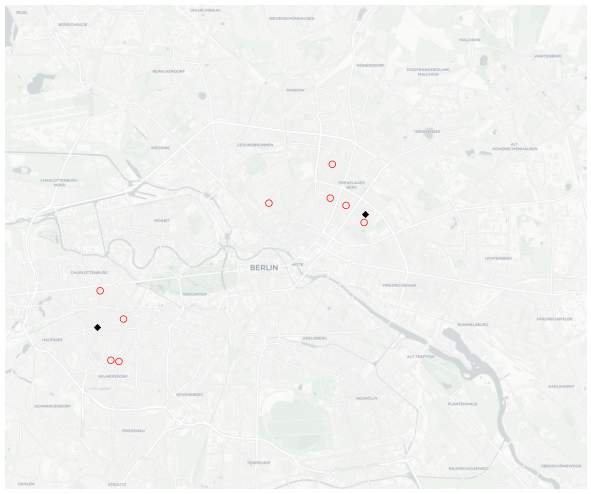

In [5]:
fig, ax = plt.subplots(1,1, figsize=(15,15))
img, ext = cx.bounds2img(*bbox, ll=True, source=BASEMAP_SOURCE)
_ = ax.imshow(img, extent=ext)
vehicle_df = gpd.GeoDataFrame(geometry=[Point(vehicle.start[0],vehicle.start[1]) for vehicle in vehicles], crs="EPSG:4326").to_crs("EPSG:3857")
job_df = gpd.GeoDataFrame(geometry=[Point(job.location[0],job.location[1]) for job in jobs], crs="EPSG:4326").to_crs("EPSG:3857")
vehicle_df.plot(ax=ax, **JOB_PLOT_KWDS)
job_df.plot(ax=ax, **VEHICLE_PLOT_KWDS)

_ = ax.axis("off")

In [6]:
O = vroom.optimization(
    vehicles=vehicles,
    jobs=jobs,
    geometry=True,
)

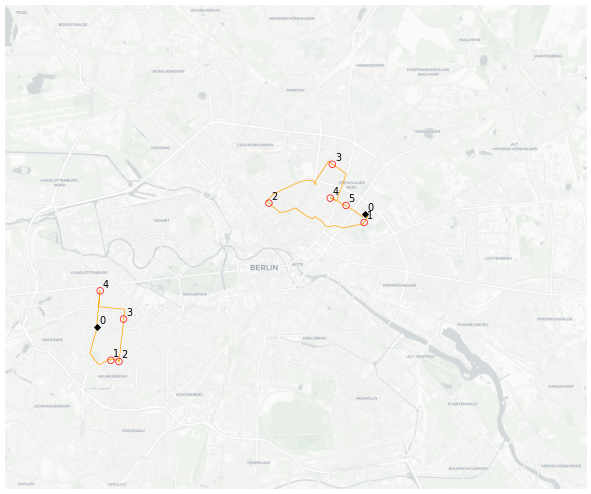

In [7]:
fig, ax = plt.subplots(1,1, figsize=(15,15))
img, ext = cx.bounds2img(*bbox, ll=True, source=BASEMAP_SOURCE)
_ = ax.imshow(img, extent=ext)
routes_df = gpd.GeoDataFrame(geometry=[LineString(route.geometry) for route in O.routes], crs="EPSG:4326").to_crs("EPSG:3857")
routes_df.plot(ax=ax, **ROUTE_PLOT_KWDS)
vehicle_df = gpd.GeoDataFrame(geometry=[Point(vehicle.start[0],vehicle.start[1]) for vehicle in vehicles], crs="EPSG:4326").to_crs("EPSG:3857")
job_df = gpd.GeoDataFrame(geometry=[Point(job.location[0],job.location[1]) for job in jobs], crs="EPSG:4326").to_crs("EPSG:3857")
vehicle_df.plot(ax=ax, **JOB_PLOT_KWDS, zorder=2)
job_df.plot(ax=ax, **VEHICLE_PLOT_KWDS, zorder=3)

for r in O.routes:
    steps_df = gpd.GeoDataFrame(geometry=[Point(step.location[0],step.location[1]) for step in r.steps], crs="EPSG:4326").to_crs("EPSG:3857")
    for ix, step in steps_df.iterrows():
        if ix != len(steps_df) - 1:
            ax.annotate(text=str(ix), xy=[step.geometry.x, step.geometry.y], xytext=(8, 5), textcoords="offset points",
                 horizontalalignment='center', fontsize=14)
        
_ = ax.axis("off")

## 3. Custom matrices

vroom allows us to provide our own custom matrices as an input instead of vroom calling a routing engine in the backend. Sadly, vrooms demo server seems to disallow this, so we spin up a local vroom instance.

In [8]:
from routingpy import Valhalla

In [9]:
v = Valhalla("http://valhalla1.openstreetmap.de")

In [10]:
vroom_local = Vroom("http://localhost:3000")  # beware: local vroom instance needed running on port 3000 for this!

In [11]:
matrix_locations = [*[vehicle.start for vehicle in vehicles], *[job.location for job in jobs]]

In [12]:
matrix = v.matrix(matrix_locations, profile="auto")

In [13]:
vehicles_indexed = [
    Vehicle(
        id=ix,
        start_index=ix,
        end_index=ix
    ) for ix, vehicle in enumerate(vehicles)
]

In [14]:
jobs_indexed = [
    Job(
        id=len(vehicles) + ix,
        location_index=len(vehicles) + ix
    ) for ix, job in enumerate(jobs)
]

In [15]:
O_indexed = vroom_local.optimization(
    vehicles=vehicles_indexed,
    jobs=jobs_indexed,
    matrices={"car": {"durations" : matrix.durations}},
    geometry=False,
    dry_run=False
)

In [16]:
O_indexed

Optimization(code: 0, error: None, cost: 1557)